Taking inspiration from this [post](https://stackoverflow.com/questions/77508682/correct-way-to-do-lagrange-dual-optimization-pytorch), we will use the PyTorch Adam Optimizer to solve the Lagrangain dual problem. 

In [1]:
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from gurobipy import GRB, quicksum, Model

Running an optimizer on the linear system of equations:
$$
x_0 + x_1 - 5 = 0 (eq.1)
$$
$$
2x_0 - x_1 + 3 = 0 (eq.2)
$$
where the loss is defined to be:
$$
(eq.1)^2 + (eq.2)^2
$$
and the Adam optimizer is being used to minimize this loss. 
The exact solutions are 
$$
x_0 = \frac{2}{3}
$$
$$
x_1 = \frac{13}{3}
$$

In [3]:
# Define your system of equations as a function
def equations(x):
    eq1 = x[0] + x[1] - 5
    eq2 = 2*x[0] - x[1] + 3
    return eq1, eq2

# Initialize the variables 
x = torch.tensor([0.,0.], requires_grad=True)

# Define the Adam optimizer
optimizer = Adam([x], lr=0.01, maximize=False)

# Set a threshold for the loss
loss_threshold = 1e-6

# Optimization loop
step = 0
while True:
    # Compute the system of equations
    eq1, eq2 = equations(x)
    
    # Define the loss as the sum of squared equations
    loss = eq1**2 + eq2**2

    # Print the loss at each step
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

    # Check if the loss is below the threshold
    if abs(loss.item()) < loss_threshold:
        break

    # Zero the gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update the variables
    optimizer.step()

    step += 1

# The optimized values for the variables
solution = x.detach().numpy()
print("Optimized solution:", solution)


Step 0, Loss: 34.0
Step 100, Loss: 20.551959991455078
Step 200, Loss: 11.665807723999023
Step 300, Loss: 6.137031555175781
Step 400, Loss: 2.9643564224243164
Step 500, Loss: 1.3036264181137085
Step 600, Loss: 0.5183063745498657
Step 700, Loss: 0.18529455363750458
Step 800, Loss: 0.05931048095226288
Step 900, Loss: 0.016934897750616074
Step 1000, Loss: 0.004297736566513777
Step 1100, Loss: 0.0009654018795117736
Step 1200, Loss: 0.00019103451631963253
Step 1300, Loss: 3.309983731014654e-05
Step 1400, Loss: 4.998842086934019e-06
Optimized solution: [0.6665166 4.33259  ]


Running an optimizer on the quadratic equation:
$$
y = x_t^2
$$
where the loss is defined to be:
$$
y
$$
and the Adam optimizer is being used to minimize this loss. 
The exact solution is
$$
x_t = 0
$$

In [4]:
# test on a simple parabola
x_t = torch.rand(1,1, requires_grad=True)
print(f"x_t: {x_t}")
optimizer = torch.optim.Adam([x_t], lr=0.01, maximize=False)
# Set a threshold for the loss
loss_threshold = 1e-8

# Optimization loop
step = 0
while True:

    loss = x_t**2

    # Print the loss at each step
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

    # Check if the loss is below the threshold
    if abs(loss.item()) < loss_threshold:
        break

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    step += 1

# The optimized values for the variables
solution = x_t.detach().numpy()
print("Optimized solution:", solution)

x_t: tensor([[0.9906]], requires_grad=True)
Step 0, Loss: 0.981256365776062
Step 100, Loss: 0.04736644774675369
Step 200, Loss: 0.00020352439605630934
Step 300, Loss: 1.983038089292677e-08
Optimized solution: [[9.470147e-05]]


In [5]:
# test on a simple parabola
x_t = torch.rand(1,1, requires_grad=True)
print(f"x_t: {x_t}")
optimizer = torch.optim.Adam([x_t], lr=0.01, maximize=True)
# Set a threshold for the loss
loss_threshold = 1e-8

# Optimization loop
step = 0
while True:

    loss = -x_t**2

    # Print the loss at each step
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

    # Check if the loss is below the threshold
    if abs(loss.item()) < loss_threshold:
        break

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    step += 1

# The optimized values for the variables
solution = x_t.detach().numpy()
print("Optimized solution:", solution)

x_t: tensor([[0.2674]], requires_grad=True)
Step 0, Loss: -0.07150442898273468
Optimized solution: [[7.715425e-06]]


Since Gurobi will be needed to validate answers later on, here is a simple example using the Gurobi module.

minimize $5x + 4y$

subject to
$$x + y \geq 8$$
$$2x + y \geq 10$$
$$x + 4y \geq 11$$
$$x \geq 0$$
$$y \geq 0$$

In [6]:
from gurobipy import *
opt_mod = Model(name = "simple_linear_program_1")

# add variables
x = opt_mod.addVar(name='x', vtype=GRB.CONTINUOUS, lb=0)
y = opt_mod.addVar(name='y', vtype=GRB.CONTINUOUS, lb=0)

# set the objective function
obj_fn = 5*x + 4*y
opt_mod.setObjective(obj_fn, GRB.MINIMIZE)

# adding the constraints
c1 = opt_mod.addConstr(x + y >= 8, name='c1')
c2 = opt_mod.addConstr(2*x + y >= 10, name='c2')
c3 = opt_mod.addConstr(x + 4*y >= 11, name='c3')

# now optimize the problem and save it to a file
opt_mod.optimize()
opt_mod.write("simpe_linear_model_one.lp")

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)



CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 3 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x6c7cdc94
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [4e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+01]
Presolve time: 0.00s
Presolved: 3 rows, 2 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.850000e+01   0.000000e+00      0s
       2    3.4000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.400000000e+01
Objective Function Value: 34.000000
x: 2
y: 6


This example shows how to use the Adam optimizer to solve a Lagrangian dual problem. The objective function be to minimized is: 
$$
2x_1 + 4x_2 = 0
$$
And the constraints are: 
$$
-x_1 - 5 = 0
$$
$$
-x_2 - 5 = 0
$$
The Lagrangian thus becomes:
$$
L(x, \lambda) = 2x_1 + 4x_2 + \lambda_1(-x_1 - 5) + \lambda_2(-x_2 - 5)
$$

For my personal purposes, I do not need to modify $x$, solely $\lambda$, therefore this is not a dual optimization problem but a simple maximization of $\lambda$. 

Thus, assuming $x$ is given and does not violate constraints, we will obtain the gradients:
$$
\nabla_{x_1}L(x,\lambda) = 2 - \lambda_1 = 0
$$
$$
\nabla_{x_2}L(x,\lambda) = 4 - \lambda_2 = 0
$$
$$
\nabla_{\lambda_1}L(x,\lambda) = -x_1 - 5 = 0
$$
$$
\nabla_{\lambda_2}L(x,\lambda) = -x_2 - 5 = 0
$$
Giving the exact solutions:
$$
x_1 = -5
$$
$$
x_2 = -5
$$
$$
\lambda_1 = 2
$$
$$
\lambda_2 = 4
$$

In [5]:
# double checking that these are indeed the exact solutions as I stated above
A = np.array([[0,0,-1,0],[0,0,0,-1],[-1,0,0,0],[0,-1,0,0]])
b = np.array([-2,-4,5,5])
x = np.linalg.solve(A,b)
print(x)

[-5. -5.  2.  4.]


In [6]:
c = np.array([2,4], dtype='float32').reshape(-1,1)
n = 2 # input of dimension 2
m = 2 # 2 constraints
A = np.array([[-1, 0], [0, -1]], dtype='float32')
b = np.array([-5,-5], dtype='float32').reshape(-1, 1)
print(f"A: {A}")
print(f"b: {b}")
print(f"c: {c}")

A: [[-1.  0.]
 [ 0. -1.]]
b: [[-5.]
 [-5.]]
c: [[2.]
 [4.]]


In [7]:
c_t = torch.tensor(c).float()
A_t = torch.tensor(A).float()
b_t = torch.tensor(b).float().reshape(-1,1)
# x_t = torch.rand(n, 1, requires_grad=True)
x_t = torch.tensor([-5.0,-5.0], requires_grad=True).float().reshape(-1,1)
print(f"A: {A_t.detach().numpy()}")
print(f"b: {b_t.detach().numpy()}")
print(f"c: {c_t.detach().numpy()}")
print(f"x_t: {x_t.detach().numpy()}")

_lagrange_multiplier = torch.rand(m,1, requires_grad=True)
lagrange_multiplier = torch.nn.functional.softplus(_lagrange_multiplier)
print(f"Init lagrange_multiplier {lagrange_multiplier.detach().numpy()}")

# opt_weights = torch.optim.Adam([x_t], lr=0.1)
opt_lagrange = torch.optim.Adam([_lagrange_multiplier], lr=0.1, maximize=True)

# Set a threshold for the loss
loss_threshold = 1e-8

# Optimization loop
step = 0
while True:
    

    objective = c_t.T @ x_t
    constraint = A_t @ x_t + b_t
    
    lagrange_multiplier = torch.nn.functional.softplus(_lagrange_multiplier)
    lagrangian = objective + lagrange_multiplier.T @ constraint
    lagrangian = lagrangian.squeeze()
    if step == 0:
        print(f"lagrangian shape: {lagrangian.shape}")
        print(f"Shape objective {objective.shape}, Shape constraint {constraint.shape}")
        print(f"objective: {objective}")
        print(f"constraint: {constraint}")
        print(f"lagrangian: {lagrangian}")

        # Print the loss at each step
    if step % 100 == 0:
        print(f"Step {step}, Loss: {lagrangian.item()}, lambda_1: {_lagrange_multiplier[0]}, lambda_2: {_lagrange_multiplier[1]}")

    # Check if the loss is below the threshold
    if abs(lagrangian.item()) < loss_threshold:
        break
        
    # zero the gradient
    opt_lagrange.zero_grad()

    # compute the gradient
    lagrangian.backward()

    # update values
    opt_lagrange.step()

    step += 1

A: [[-1.  0.]
 [ 0. -1.]]
b: [[-5.]
 [-5.]]
c: [[2.]
 [4.]]
x_t: [[-5.]
 [-5.]]
Init lagrange_multiplier [[0.873101 ]
 [0.8700457]]
lagrangian shape: torch.Size([])
Shape objective torch.Size([1, 1]), Shape constraint torch.Size([2, 1])
objective: tensor([[-30.]], grad_fn=<MmBackward0>)
constraint: tensor([[0.],
        [0.]], grad_fn=<AddBackward0>)
lagrangian: -30.0
Step 0, Loss: -30.0, lambda_1: tensor([0.3324], grad_fn=<SelectBackward0>), lambda_2: tensor([0.3272], grad_fn=<SelectBackward0>)
Step 100, Loss: -30.0, lambda_1: tensor([0.3324], grad_fn=<SelectBackward0>), lambda_2: tensor([0.3272], grad_fn=<SelectBackward0>)
Step 200, Loss: -30.0, lambda_1: tensor([0.3324], grad_fn=<SelectBackward0>), lambda_2: tensor([0.3272], grad_fn=<SelectBackward0>)
Step 300, Loss: -30.0, lambda_1: tensor([0.3324], grad_fn=<SelectBackward0>), lambda_2: tensor([0.3272], grad_fn=<SelectBackward0>)
Step 400, Loss: -30.0, lambda_1: tensor([0.3324], grad_fn=<SelectBackward0>), lambda_2: tensor([0.3272]

KeyboardInterrupt: 

x1: -5.0 is leaf True, x2: -5.0 is leaf True, x3: tensor([0.0566], requires_grad=True) is leaf True, x4: tensor([0.8357], requires_grad=True) is leaf True
Optimized x1: -5.0
Optimized x2: -5.0
Optimized x3: 0.05660974979400635
Optimized x4: 0.835723876953125


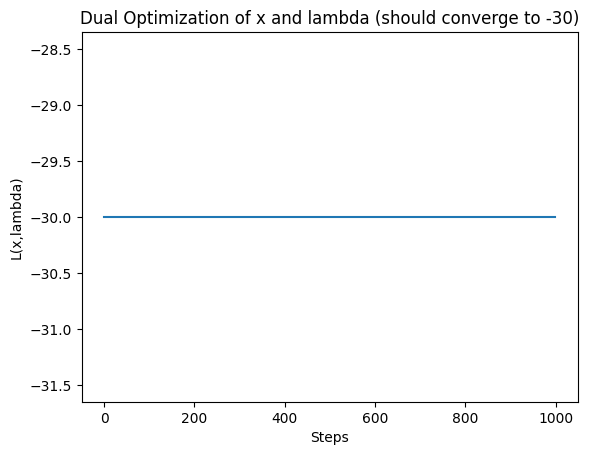

In [3]:
# Using Adam
# Initialize the parameters you want to optimize
x1_opt = torch.tensor(-5.0, requires_grad=False)
x2_opt = torch.tensor(-5.0, requires_grad=False)
x3_opt = torch.rand(1, requires_grad=True)
x4_opt = torch.rand(1, requires_grad=True)
print(f"x1: {x1_opt} is leaf {x1_opt.is_leaf}, x2: {x2_opt} is leaf {x2_opt.is_leaf}, x3: {x3_opt} is leaf {x3_opt.is_leaf}, x4: {x4_opt} is leaf {x4_opt.is_leaf}")

# Define the objective function
def objective_function(x1, x2, x3, x4):
    return 2*x1 + 4*x2 + x3*(-x1 - 5) + x4*(-x2 - 5)

# Number of optimization steps
num_steps = 1000
lr = 0.1

loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

opt = torch.optim.Adam([x3_opt, x4_opt], lr=lr, maximize=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

# Optimization loop
for step in range(num_steps):

    # Compute the objective function
    y = objective_function(x1_opt, x2_opt, x3_opt, x4_opt).sum()
    loss_graph[1, step] = y.item()

    opt.zero_grad(set_to_none=True)

    y.backward()

    opt.step()

    # clip lagrange values
    x3_opt.data = torch.clip(x3_opt.data, 0)
    x4_opt.data = torch.clip(x4_opt.data, 0)

    scheduler.step()

# The optimized values for x3 and x4
x1_optimized = x1_opt.item()
x2_optimized = x2_opt.item()
x3_optimized = x3_opt.item()
x4_optimized = x4_opt.item()

print("Optimized x1:", x1_optimized)
print("Optimized x2:", x2_optimized)
print("Optimized x3:", x3_optimized)
print("Optimized x4:", x4_optimized)

fig = plt.figure()
plt.title("Dual Optimization of x and lambda (should converge to -30)")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

x1: tensor([0.6116], dtype=torch.float64, requires_grad=True) is leaf True, x2: tensor([0.0295], dtype=torch.float64, requires_grad=True) is leaf True, x3: tensor([0.1955], dtype=torch.float64, requires_grad=True) is leaf True, x4: tensor([0.9048], dtype=torch.float64, requires_grad=True) is leaf True
Optimized x1: -4.55081800782109
Optimized x2: -5.225714517952417
Optimized x3: 0.0
Optimized x4: 0.29730698177256015


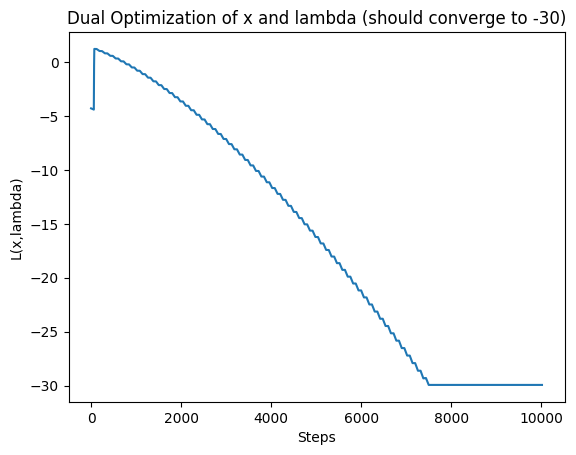

In [29]:
# Using Adam
# Initialize the parameters you want to optimize
x1_opt = torch.rand(1,dtype=torch.float64, requires_grad=True)
x2_opt = torch.rand(1,dtype=torch.float64, requires_grad=True)
x3_opt = torch.rand(1,dtype=torch.float64, requires_grad=True)
x4_opt = torch.rand(1,dtype=torch.float64, requires_grad=True)
print(f"x1: {x1_opt} is leaf {x1_opt.is_leaf}, x2: {x2_opt} is leaf {x2_opt.is_leaf}, x3: {x3_opt} is leaf {x3_opt.is_leaf}, x4: {x4_opt} is leaf {x4_opt.is_leaf}")

# Define the objective function
def objective_function(x1, x2, x3, x4):
    return 2*x1 + 4*x2 + x3*(-x1 - 5) + x4*(-x2 - 5)

# Number of optimization steps
num_steps = 10000 + 20
lr = 0.1

flip = True

loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

opt_duals = torch.optim.Adam([x3_opt, x4_opt], lr=lr, maximize=True)
opt_x = torch.optim.Adadelta([x1_opt, x2_opt], lr=lr, maximize=False)
scheduler_dual = torch.optim.lr_scheduler.ExponentialLR(opt_duals, 0.98)
scheduler_x = torch.optim.lr_scheduler.ExponentialLR(opt_x, 0.98)

# Optimization loop
for step in range(num_steps):

    # Compute the objective function
    y = objective_function(x1_opt, x2_opt, x3_opt, x4_opt).sum()
    loss_graph[1, step] = y.item()

    opt_x.zero_grad(set_to_none=True)
    opt_duals.zero_grad(set_to_none=True)
    y.backward()

    if flip:
        opt_x.step()
        # if step % 20 == 0:
        #     scheduler_x.step()
    else:
        opt_duals.step()
        # if step % 20 == 0:
        #     scheduler_dual.step()
    
    # clip lagrange values
    x3_opt.data = torch.clip(x3_opt.data, 0)
    x4_opt.data = torch.clip(x4_opt.data, 0)

    if step != 0 and step % 60 == 0:
        flip = not flip
    
    if loss_graph[1, step] < -29.5 and loss_graph[1,step] > -30.5 and flip == False:
        loss_graph[1, step:] = loss_graph[1,step]
        break

# The optimized values for x3 and x4
x1_optimized = x1_opt.item()
x2_optimized = x2_opt.item()
x3_optimized = x3_opt.item()
x4_optimized = x4_opt.item()

print("Optimized x1:", x1_optimized)
print("Optimized x2:", x2_optimized)
print("Optimized x3:", x3_optimized)
print("Optimized x4:", x4_optimized)

fig = plt.figure()
plt.title("Dual Optimization of x and lambda (should converge to -30)")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

x1: tensor([0.7194], requires_grad=True) is leaf True, x2: tensor([0.2687], requires_grad=True) is leaf True, x3: tensor([0.7701], requires_grad=True) is leaf True, x4: tensor([0.8334], requires_grad=True) is leaf True
Optimized x1: -4.999998092651367
Optimized x2: -4.999998092651367
Optimized x3: 1.9999995231628418
Optimized x4: 3.9999990463256836


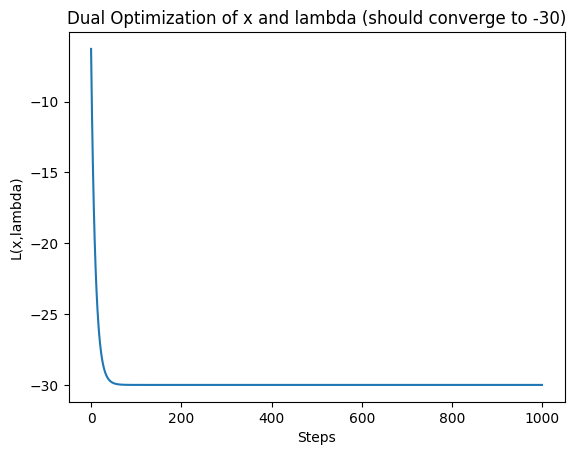

In [19]:
# Initialize the parameters you want to optimize
x1_opt = torch.rand(1, requires_grad=True)
x2_opt = torch.rand(1, requires_grad=True)
x3_opt = torch.rand(1, requires_grad=True)
x4_opt = torch.rand(1, requires_grad=True)
print(f"x1: {x1_opt} is leaf {x1_opt.is_leaf}, x2: {x2_opt} is leaf {x2_opt.is_leaf}, x3: {x3_opt} is leaf {x3_opt.is_leaf}, x4: {x4_opt} is leaf {x4_opt.is_leaf}")

# Define the objective function
def objective_function(x1, x2, x3, x4):
    return 2*x1 + 4*x2 + x3*(-x1 - 5) + x4*(-x2 - 5)

def zero_grad(parameters):
    for p in parameters:
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()

# Number of optimization steps
num_steps = 1000
lr = 0.1
flip = True

loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

# Optimization loop
for step in range(num_steps):

    # Compute the objective function
    y = objective_function(x1_opt, x2_opt, x3_opt, x4_opt)
    y.backward()

    grad1 = x1_opt.grad if x1_opt.grad is not None else 0.0
    grad2 = x2_opt.grad if x2_opt.grad is not None else 0.0
    grad3 = x3_opt.grad if x3_opt.grad is not None else 0.0
    grad4 = x4_opt.grad if x4_opt.grad is not None else 0.0

    loss_graph[1, step] = y.item()
    
    if flip:
        # when this is true, we are minimizing L(x,lambda) w.r.t. x
        x1_opt.data = (x1_opt.data + lr*grad3).requires_grad_(True)
        x2_opt.data = (x2_opt.data + lr*grad4).requires_grad_(True)        

    else:
        # when this is false, we are maximizing L(x,lambda) w.r.t. lambda
        x3_opt.data = torch.clamp(x3_opt.data + lr*grad1, min=0.0).requires_grad_(True)
        x4_opt.data = torch.clamp(x4_opt.data + lr*grad2, min=0.0).requires_grad_(True)

    # if step != 0 and (step % 100) == 0:
    #     print(f"Step {step}, Loss: {y.item():.4f}, x1: {x1_opt.detach().numpy()[0]:.4f} x2: {x2_opt.detach().numpy()[0]:.4f} lambda_1: {x3_opt.detach().numpy()[0]:.4f}, lambda_2: {x4_opt.detach().numpy()[0]:.4f}, grads: [{x1_opt.grad.detach().numpy()[0]:.4f}, {x2_opt.grad.detach().numpy()[0]:.4f}, {x3_opt.grad.detach().numpy()[0]:.4f}, {x4_opt.grad.detach().numpy()[0]:.4f}]")

    if step != 0 and (step % 100) == 0:
        flip = not flip
        
    # zero out the gradients
    zero_grad([x1_opt, x2_opt, x3_opt, x4_opt])

# The optimized values for x3 and x4
x1_optimized = x1_opt.item()
x2_optimized = x2_opt.item()
x3_optimized = x3_opt.item()
x4_optimized = x4_opt.item()

print("Optimized x1:", x1_optimized)
print("Optimized x2:", x2_optimized)
print("Optimized x3:", x3_optimized)
print("Optimized x4:", x4_optimized)

fig = plt.figure()
plt.title("Dual Optimization of x and lambda (should converge to -30)")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

Optimized x1: -0.8333324193954468
Optimized x2: -0.8333352208137512
Optimized l1: 1.045896053314209
Optimized l2: 0.2871112823486328
Optimized l3: 0.0
Optimized l4: 1.4137334823608398
Optimized l5: 0.5862621068954468


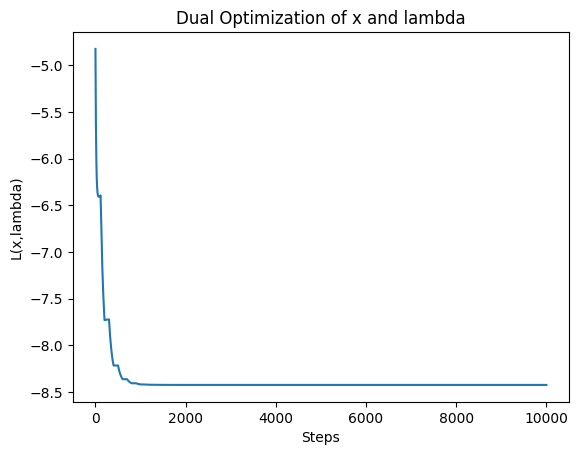

In [51]:
# Initialize the parameters you want to optimize
x1_opt = torch.rand(1, requires_grad=True)
x2_opt = torch.rand(1, requires_grad=True)
l1_opt = torch.rand(1, requires_grad=True)
l2_opt = torch.rand(1, requires_grad=True)
l3_opt = torch.rand(1, requires_grad=True)
l4_opt = torch.rand(1, requires_grad=True)
l5_opt = torch.rand(1, requires_grad=True)

# Define the objective function
def objective_function(x1, x2, l1, l2, l3, l4, l5):
    return x1 + 2*x2 + l1*(x1-2) + l2*(-x1-2) + l3*(x2-2) + l4*(-x2-2) + l5*(-3*x1 - x2 - 5)

def zero_grad(parameters):
    for p in parameters:
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()

# Number of optimization steps
num_steps = 10000
lr = 0.01
flip = True

loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

# Optimization loop
for step in range(num_steps):

    # Compute the objective function
    y = objective_function(x1_opt, x2_opt, l1_opt, l2_opt, l3_opt, l4_opt, l5_opt)
    y.backward()

    x_grad1 = x1_opt.grad if x1_opt.grad is not None else 0.0
    x_grad2 = x2_opt.grad if x2_opt.grad is not None else 0.0
    l_grad1 = l1_opt.grad if l1_opt.grad is not None else 0.0
    l_grad2 = l2_opt.grad if l2_opt.grad is not None else 0.0
    l_grad3 = l3_opt.grad if l3_opt.grad is not None else 0.0
    l_grad4 = l4_opt.grad if l4_opt.grad is not None else 0.0
    l_grad5 = l5_opt.grad if l5_opt.grad is not None else 0.0

    loss_graph[1, step] = y.item()
    
    if flip:
        # when this is true, we are minimizing L(x,lambda) w.r.t. x
        x1_opt.data = (x1_opt.data + lr*(-l_grad1 + l_grad2 + l_grad5)).requires_grad_(True)
        x2_opt.data = (x2_opt.data + lr*(-l_grad3 + l_grad4 + l_grad5)).requires_grad_(True)        

    else:
        # when this is false, we are maximizing L(x,lambda) w.r.t. lambda
        l1_opt.data = torch.clamp(l1_opt.data + lr*(-x_grad1), min=0.0).requires_grad_(True)
        l2_opt.data = torch.clamp(l2_opt.data + lr*(x_grad1), min=0.0).requires_grad_(True)
        l3_opt.data = torch.clamp(l3_opt.data + lr*(-x_grad2), min=0.0).requires_grad_(True)
        l4_opt.data = torch.clamp(l4_opt.data + lr*(x_grad2), min=0.0).requires_grad_(True)
        l5_opt.data = torch.clamp(l5_opt.data + lr*(x_grad1 + x_grad2), min=0.0).requires_grad_(True)

    if step != 0 and (step % 100) == 0:
        flip = not flip
        
    # zero out the gradients
    zero_grad([x1_opt, x2_opt, l1_opt, l2_opt, l3_opt, l4_opt, l5_opt])

# The optimized values for x3 and x4
x1_optimized = x1_opt.item()
x2_optimized = x2_opt.item()
l1_optimized = l1_opt.item()
l2_optimized = l2_opt.item()
l3_optimized = l3_opt.item()
l4_optimized = l4_opt.item()
l5_optimized = l5_opt.item()

print("Optimized x1:", x1_optimized)
print("Optimized x2:", x2_optimized)
print("Optimized l1:", l1_optimized)
print("Optimized l2:", l2_optimized)
print("Optimized l3:", l3_optimized)
print("Optimized l4:", l4_optimized)
print("Optimized l5:", l5_optimized)

fig = plt.figure()
plt.title("Dual Optimization of x and lambda")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

Below I am checking the results of the Lagrange problem above by computing the upper and lower bounds on x as well as the minimal and maximal pertubation on each logit output

In [54]:
W_ub = np.array([[4,3],[4,3]])
b_ub = np.array([2,2])
W_lb = np.array([[1,2],[1,1]])
# b_lb = np.array([1,1])
b_lb = np.zeros(2)
# using Gurobi to solve the same problem as above
opt_mod = Model(name = "simple_linear_program_2")

# add variables
inputs = np.array(list(opt_mod.addVars(W_ub.shape[1], name="x", lb=float("-inf"), ub=float("inf")).values()))

# adding the constraints
c1 = opt_mod.addConstr(inputs[0] - 2 <= 0, name='c1') # these four constraints are the l_inf norm box constraints
c2 = opt_mod.addConstr(-inputs[0] - 2 <= 0, name='c2')
c3 = opt_mod.addConstr(inputs[1] - 2 <= 0, name='c3')
c4 = opt_mod.addConstr(-inputs[1] - 2 <= 0, name='c4')
c5 = opt_mod.addConstr(-3*inputs[0] - inputs[1] - 5 <= 0, name='c5') # this constraint is a line constraint cutting through the box

worst_case_inputs_ub = []
worst_case_inputs_lb = []
upper_bounds = []
lower_bounds = []

# set the objective function for each logit
for idx in range(2*W_ub.shape[0]):
    i = idx // 2
    if idx % 2 == 0:
        obj_fn = quicksum([W_ub[i,j]*inputs[j] for j in range(W_ub.shape[1])]) + b_ub[i]
        opt_mod.setObjective(obj_fn, GRB.MAXIMIZE)
    else:
        obj_fn = quicksum([W_lb[i,j]*inputs[j] for j in range(W_lb.shape[1])]) + b_lb[i]
        opt_mod.setObjective(obj_fn, GRB.MINIMIZE)

    # now optimize the problem and save it to a file
    opt_mod.optimize()
    # opt_mod.write("scenario_one_upperbound_logit_one.lp")

    # output the result
    # print('Objective Function Value: %f' % opt_mod.ObjVal)
    if idx % 2 == 0:
        upper_bounds.append(opt_mod.ObjVal)
    else:
        lower_bounds.append(opt_mod.ObjVal)
    # Get values of the decision variables
    temp_inputs = []
    for v in opt_mod.getVars():
        # print('%s: %g' % (v.VarName, v.x))
        temp_inputs.append(v.x)

    if idx % 2 == 0:
        worst_case_inputs_ub.append(tuple(temp_inputs)) # append the worst case input that caused this maximal pertubation
    else:
        worst_case_inputs_lb.append(tuple(temp_inputs)) # append the worst case input that caused this maximal pertubation
    
for i in range(W_ub.shape[0]):
    print(f"logit {i + 1} is bounded s.t. {lower_bounds[i]} <= z(x) <= {upper_bounds[i]} with lb pertubation {worst_case_inputs_lb[i]} and ub pertubation {worst_case_inputs_ub[i]}")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 5 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xf5f961a3
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.600000000e+01
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 th

In [ ]:
import numpy as np
from scipy.optimize import linprog

# Primal linear program coefficients
c = np.array([2, 3])
A = np.array([[1, -1], [3, 1]])
b = np.array([1, 2])

# Solve the primal linear program
result_primal = linprog(c, A_ub=A, b_ub=b, method='highs')

# Display the primal result
print("Primal Result:")
print(result_primal)

# Dual linear program coefficients
c_dual = -b  # Coefficients are negated for maximization
A_dual = -A.T  # Transpose of A with negation
b_dual = c  # Dual variables corresponding to the inequality constraints

# Solve the dual linear program
result_dual = linprog(c_dual, A_ub=A_dual, b_ub=b_dual, method='highs')

# Display the dual result
print("\nDual Result:")
print(result_dual)


Primal Result:
       message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
       success: True
        status: 0
           fun: 0.0
             x: [ 0.000e+00  0.000e+00]
           nit: 0
         lower:  residual: [ 0.000e+00  0.000e+00]
                marginals: [ 2.000e+00  3.000e+00]
         upper:  residual: [       inf        inf]
                marginals: [ 0.000e+00  0.000e+00]
         eqlin:  residual: []
                marginals: []
       ineqlin:  residual: [ 1.000e+00  2.000e+00]
                marginals: [-0.000e+00 -0.000e+00]

Dual Result:
       message: The problem is unbounded. (HiGHS Status 10: model_status is Unbounded; primal_status is At upper bound)
       success: False
        status: 3
           fun: None
             x: None
           nit: 0
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: N

In [ ]:
# potentially look into this for solving the lagrange dual, but it requires the gradients to be determined beforehand
from scipy.optimize import fsolve, fmin_l_bfgs_b

a = 1
nbtests = 5
minmu = 0
maxmu = 5

def lagrange(x, mu):
    return x**2 + mu * (np.exp(x) + x - a)

def lagrange_grad(x, mu):
    grad_x = 2*x + mu * (np.exp(x) + 1)
    grad_mu = np.exp(x) + x - a
    return grad_x, grad_mu

def dual(mu):
    x = fsolve(lambda x: lagrange_grad(x, mu)[0], x0=1)
    obj_val = lagrange(x, mu)
    grad = lagrange_grad(x, mu)[1]
    return -1.0*obj_val, -1.0*grad

pl = np.empty((nbtests, 2))
for i, nu in enumerate(np.linspace(minmu,maxmu,nbtests)):
    res = fmin_l_bfgs_b(dual, x0=nu, bounds=[(0,None)], factr=1e6)
    mu_opt = res[0]
    x_opt = fsolve(lambda x: lagrange_grad(x, mu_opt)[0], x0=1)
    pl[i] = [nu, *x_opt]
print(pl)

[[0.   0.  ]
 [1.25 0.  ]
 [2.5  0.  ]
 [3.75 0.  ]
 [5.   0.  ]]


In this last example, we will deal with a single dimension input and output. The input x will have a pertubation of $\epsilon=2$ and be fed to a ReLU unit, then be added by 5. This will then be the final output. This first example will have no constraints, and if alpha is tuned correctly, it should be zero s.t. alpha-CROWN produces a lower bound of 0. The actualy lower and upper bound is 5 and 7. 

This is the same example as before but with the restriction that $x\geq1$. We will add a Lagrange Multiplier. 

# Maximizing $\lambda$ after minimizing x. 
For a ReLU activation function, we may have an example where we wish to minimize $\sigma(x)$ where $\sigma$ is the ReLU function. If x is convex s.t. $-2\leq x \leq 2$, we may choose the lower bound on the input to be x and we will naturally find that the objection function is 0. The main issue is that ReLU is non-convex in nature, therefore we take inspiration from $\alpha$-CROWN and use the linear lower bound $\alpha$x to lower bound the ReLU function. This is the linear constraint that is used in the triangular relaxation of ReLU. Letting $alpha=1$ (note that we must have 0\leq \alpha \leq 1) and adding constraints, $x \geq -1$ and $x \leq 2$, we now solve the dual program, $L(x, \lambda)$. First minimize x and then maximize $\lambda$. x exists in the space $-2 \leq x \leq 2$, therefore we know that the smallest value of x is x=-2. Though this x does not fit our constraints, if $\lambda$ is optimal, we get the optimal objective value. Note that this minimum value will be -1 and not 0 because of the ReLU relaxation. The true minimum value is 0. 

## Question
Ask Zhang if it is reasonable to choose route 1 where clipping and projection is included in the projection as this leads to tigher bounds yet still valid bounds. 

Initial Lambda: tensor([[0.8509],
        [0.0250]])
Initial lpha: tensor([[1.]])
Optimized lambda: tensor([[0.],
        [1.]])
Optimized alpha: tensor([[1.]])
CROWN lower bound: -2.0, Lagrange lower bound: -1.0000001192092896


/home/jorgejc2/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jorgejc2/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0, flags=flags)


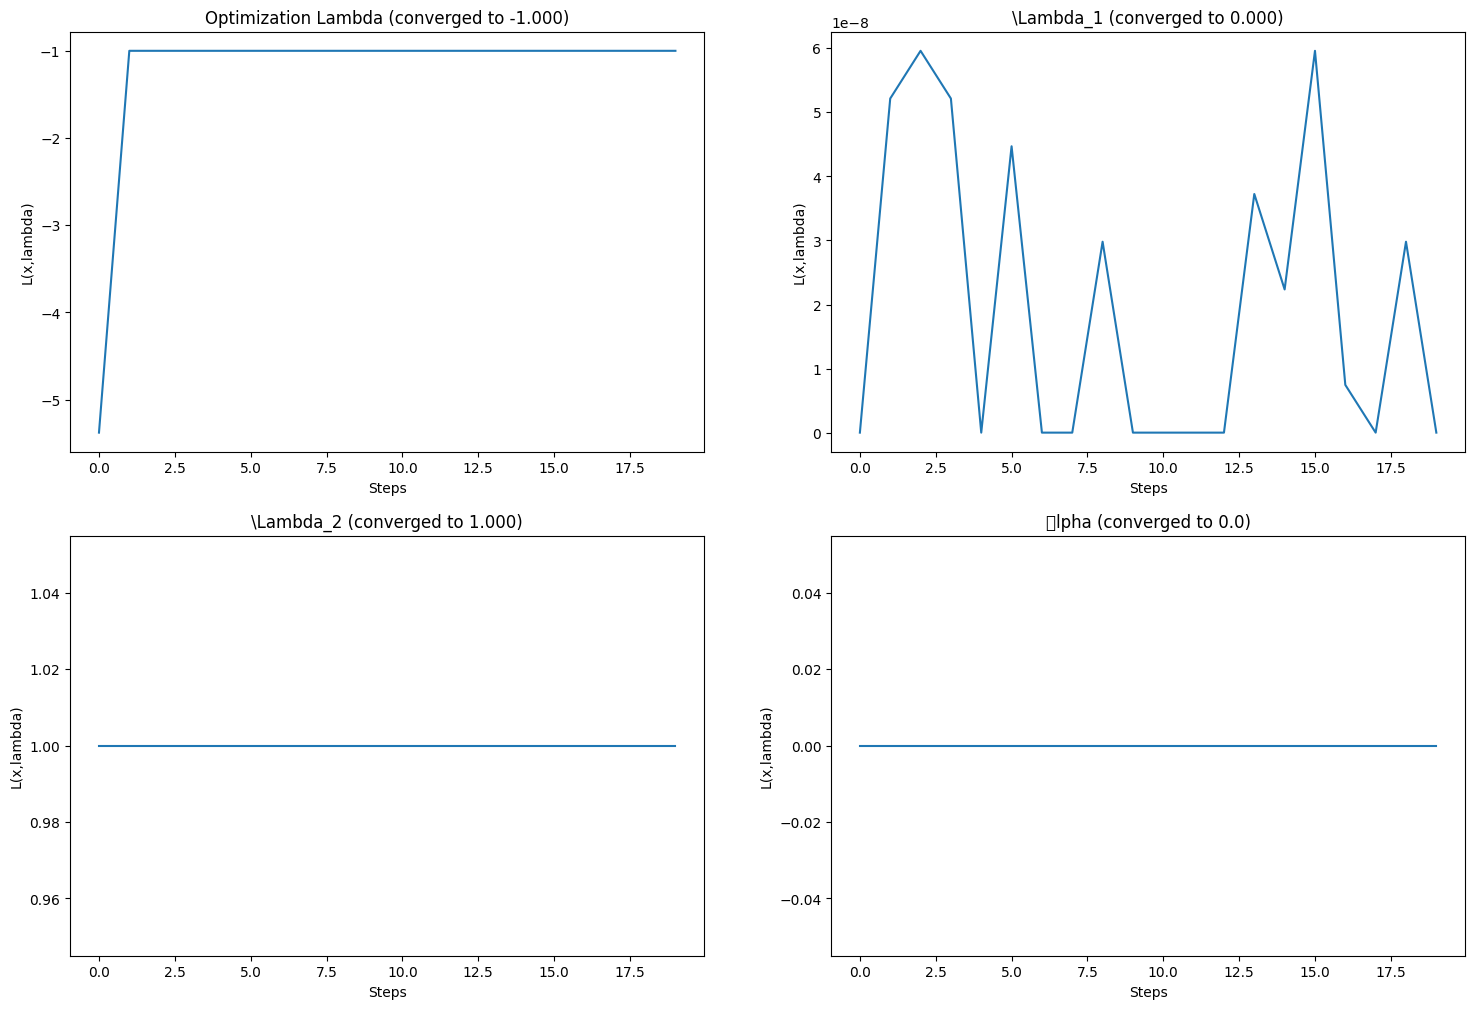

In [107]:
x = torch.tensor([[-2]]).float()
lambda_ = torch.rand(2,1, requires_grad=True)
c = torch.tensor([[1]]).float()
# c = torch.rand(1,1, requires_grad=True)
# with torch.no_grad():
#     c.data = torch.clamp(c.data, min=0, max=1)
G = torch.tensor([[1],[-1]]).float()
h = torch.tensor([[2],[1]]).float()

print(f"Initial Lambda: {lambda_.data}\nInitial \alpha: {c}")

def constraint(v, G, c):
    return -G.T @ v - c

def project_onto_lambda(v, G, c):
    # using the formula x = z - A.T(AA.T)^-1(Az-b) to project v onto the set Ax=b
    # in this example, A = -G.T, b = c
    projection = v + G @ torch.linalg.pinv(G.T@G) @ (-G.T @ v - c)
    min_val = torch.min(projection)
    if min_val < 0.0:
        projection -= min_val
    return projection
    
def obj_fn(x, lambda_, A, b, c):
    return c.T@x + lambda_.T@(A@x - b)

# Number of optimization steps
lr = 0.1
num_steps = 20

loss_graph = np.array([i for i in range(num_steps)])
lambda_vals = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))
lambda_vals = np.vstack((lambda_vals, np.zeros((3, num_steps))))

# opt = torch.optim.Adam([lambda_, c], lr=lr, maximize=True)
opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

## Though this converges much more tightly, it is frowned upon
# Optimization loop
# for step in range(num_steps):

#     # y = obj_fn(x, lambda_, G, h, c)
#     c.data = torch.clamp(c.data, min=0, max=1)
#     projected_lambda = project_onto_lambda(lambda_, G, c)
#     lambda_vals[1:3,step] = projected_lambda.detach().clone().numpy().flatten()
#     y = obj_fn(x, projected_lambda, G, h, c)

#     loss_graph[1, step] = y.item()

#     opt.zero_grad(set_to_none=True)

#     y.backward()

#     opt.step()
#     scheduler.step()

#     with torch.no_grad():
#         # c.data = torch.clamp(c.data, min=0, max=1)
#         lambda_vals[3, step] = c.detach().clone().numpy().flatten()

## Projections and constraints should not be included in the Adam optimizer
# Optimization loop
for step in range(num_steps):

    y = obj_fn(x, lambda_, G, h, c)
    
    loss_graph[1, step] = y.item()

    opt.zero_grad(set_to_none=True)

    y.backward()

    opt.step()
    scheduler.step()

    with torch.no_grad():
        lambda_.data = project_onto_lambda(lambda_, G, c)
        lambda_vals[1:3,step] = lambda_.detach().clone().numpy().flatten()
        
    # with torch.no_grad():
    #     c.data = torch.clamp(c.data, min=0, max=1)
    #     lambda_vals[3, step] = c.detach().clone().numpy().flatten()


# The optimized values for x3 and x4
# lambda_optimized = lambda_.data
lambda_optimized = project_onto_lambda(lambda_, G, c).data
alpha_optimize = c.data

print("Optimized lambda:", lambda_optimized)
print("Optimized alpha:", alpha_optimize)

print(f"CROWN lower bound: {obj_fn(x, torch.zeros(2,1).float(), G, h, c).squeeze()}, Lagrange lower bound: {loss_graph[1,-1]}")

fig = plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title(f"Optimization Lambda (converged to {loss_graph[1,-1]:.3f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

plt.subplot(2,2,2)
plt.title(f"\Lambda_1 (converged to {lambda_vals[1,-1]:.3f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], lambda_vals[1,:])

plt.subplot(2,2,3)
plt.title(f"\Lambda_2 (converged to {lambda_vals[2,-1]:.3f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], lambda_vals[2,:])

plt.subplot(2,2,4)
plt.title(f"\alpha (converged to {lambda_vals[3,-1]:1.1f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], lambda_vals[3,:])

In [109]:
# tightest lower bound with  constraints
opt_mod = Model(name="lower_bound_model")

# constraints
G = np.array([[-2/9, 1],[-6/5, 1], [-5/3, -1], [1/8, -1], [5, 1]])
h = np.array([[46/9], [6], [25/3], [19/4], [26]])

x = opt_mod.addMVar(shape=(2,1), name='x', lb=float('-inf'), ub=float('inf'))

# adding inequality constraints
ineq_c = opt_mod.addConstr(G @ x <= h, name='c0')

opt_mod.setObjective(x[0,0] + x[1,0], GRB.MINIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 5 rows, 2 columns and 10 nonzeros
Model fingerprint: 0xd3257bed
Coefficient statistics:
  Matrix range     [1e-01, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+01]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 3 rows, 2 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5200000e+01   1.216983e+01   0.000000e+00      0s
       2   -7.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective -7.000000000e+00
Objective Function Value: -7.000000
x[0,0]: -2
x[1,0]: -5
Printing inequalit

In [110]:
opt_mod.setObjective((12/22)*(x[0,0] + x[1,0] + 10), GRB.MAXIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 5 rows, 2 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 5e+00]
  Objective range  [5e-01, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4545455e+29   2.125000e+30   5.454545e-01      0s
       2    1.0909091e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.090909091e+01
Objective Function Value: 10.909091
x[0,0]: 4
x[1,0]: 6
Printing inequality constraint dual variables:
 [[0.41779497]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.12765957]]


In [86]:
print(constraint(torch.tensor([[0.],[0.], [0.62790698], [0.37209302], [0.]]), G, lower_c).detach().clone().numpy())

[[0.]
 [0.]]


Optimized lambda: tensor([[0.0000],
        [0.0000],
        [0.7317],
        [0.2558],
        [0.0000]]) tensor([[-0.4186],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1353]])
CROWN lower bound: -10.0, Lagrange lower bound: -6.4376044273376465
CROWN upper bound: 12.0, Lagrange upper bound: 10.83309268951416
last_lower_loss -7.443249225616455
last_upper_loss-11.264433860778809
last_lower_lambda[[0.        ]
 [0.        ]
 [0.73877037]
 [0.25246984]
 [0.        ]]
last_upper_lambda[[-0.42389584]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.1441049 ]]


/home/jorgejc2/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jorgejc2/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0, flags=flags)


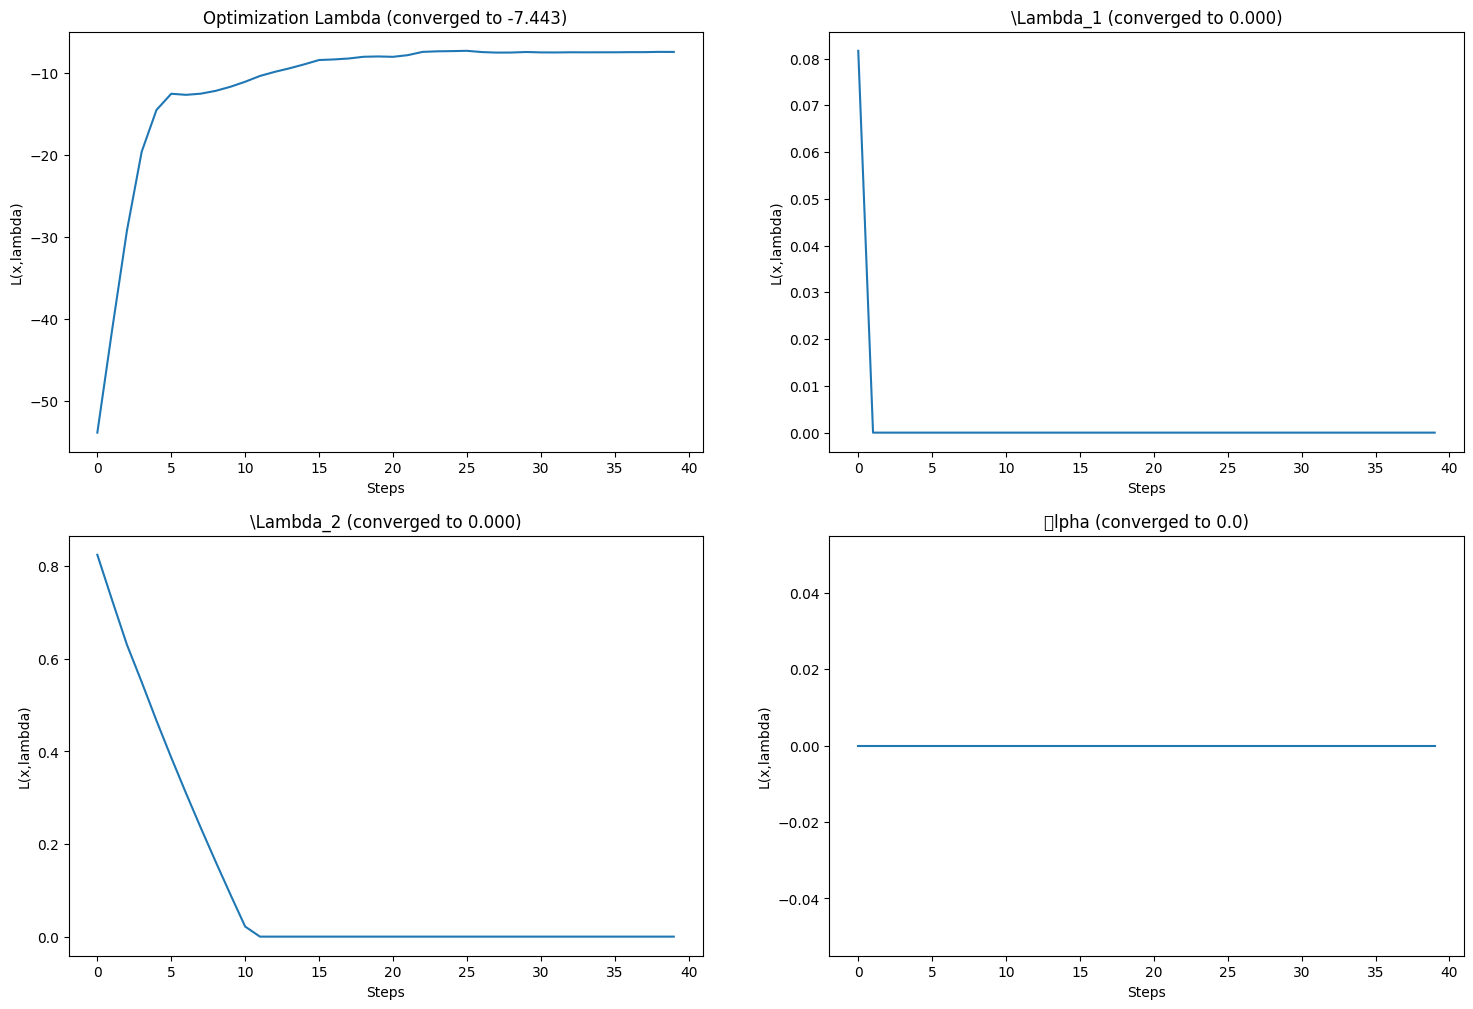

In [766]:
def constraint(v, G, c):
    return -G.T @ v - c

def project_onto_lambda(v, G, c, d):
    # print(constraint(np.linalg.lstsq(-G.detach().clone().numpy().T, c.detach().clone().numpy())[0], G, c))

    # using the formula x = z - A.T(AA.T)^-1(Az-b) to project v onto the set Ax=b
    # in this example, A = -G.T, b = c
    if np.linalg.det(G.T@G) != 0:
        projection = v + G @ torch.linalg.inv(G.T@G) @ (-G.T @ v - c)
    else:
        projection = v + G @ torch.linalg.pinv(G.T@G) @ (-G.T @ v - c)

    return projection

def obj_fn(x, d, lambda_, A, b, c, ub=False):
    if ub:
        return -1*(c.T@x + d) + lambda_.T@(A@x - b)
    else:
        return c.T@x + d + lambda_.T@(A@x - b)
    
def get_penalty(lambda_, G, c, scale=5, lb=True):
    if lb:
        return -scale*(torch.sum(torch.abs(constraint(lambda_, G, c))) + torch.sum(torch.abs(torch.clamp(lambda_, max=0.0))))
    else:
        return -scale*(torch.sum(torch.abs(constraint(lambda_, G, c))) + torch.sum(torch.abs(torch.clamp(lambda_, min=0.0))))

lower_x = torch.tensor([[-5], [-5]]).float()
upper_x = torch.tensor([[6], [6]]).float()
lambda_lower = torch.rand(5,1, requires_grad=True)
lambda_upper = torch.rand(5,1, requires_grad=True)
lower_c = torch.tensor([[1], [1]]).float()
lower_d = torch.tensor([[0]]).float()
upper_c = torch.tensor([[12/22],[12/22]]).float()
upper_d = torch.tensor([[120/22]]).float()
G = torch.tensor([[-2/9, 1],[-6/5, 1], [-5/3, -1], [1/8, -1], [5, 1]]).float()
h = torch.tensor([[46/9], [6], [25/3], [19/4], [26]]).float()

project_onto_lambda(lambda_lower, G, lower_c,0)

# print(f"Initial Lower Lambda: {lambda_lower.data}\nInitial Upper Lambda: {lambda_upper.data}\nInitial lower \alpha: {lower_c}\n Initial upper \alpha: {upper_c}")

# Number of optimization steps
lr = 0.1
num_steps = 40

loss_graph = np.array([i for i in range(num_steps)])
lambda_vals = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))
lambda_vals = np.vstack((lambda_vals, np.zeros((3, num_steps))))

# opt = torch.optim.Adam([lambda_, c], lr=lr, maximize=True)
opt_lower = torch.optim.Adam([lambda_lower], lr=lr, maximize=True)
opt_upper = torch.optim.Adam([lambda_upper], lr=lr, maximize=True)
scheduler_lower = torch.optim.lr_scheduler.ExponentialLR(opt_lower, 0.98)
scheduler_upper = torch.optim.lr_scheduler.ExponentialLR(opt_upper, 0.98)

## Projections and constraints should not be included in the Adam optimizer
# Optimization loop
for step in range(num_steps):
    
    lower_y = obj_fn(lower_x, lower_d, lambda_lower, G, h, lower_c) + get_penalty(lambda_lower, G, lower_c, lb=True)
    upper_y = -1*(obj_fn(upper_x, upper_d, lambda_upper, G, h, upper_c) - get_penalty(lambda_upper, G, upper_c, lb=False))

    
    loss_graph[1, step] = lower_y.item()

    if step == num_steps - 1:
        last_lower_loss = lower_y.item()
        last_upper_loss = upper_y.item()
        last_lower_lambda = lambda_lower.detach().clone().numpy()
        last_upper_lambda = lambda_upper.detach().clone().numpy()

    opt_lower.zero_grad(set_to_none=True)
    opt_upper.zero_grad(set_to_none=True)

    lower_y.backward()
    upper_y.backward()

    opt_lower.step()
    opt_upper.step()
    scheduler_lower.step()
    scheduler_upper.step()

    with torch.no_grad():
        
        lambda_upper.data = torch.clamp(lambda_upper.data, max=0.0)
        lambda_lower.data = torch.clamp(lambda_lower.data, min=0.0)
        lambda_vals[1:3,step] = lambda_lower.detach().clone().numpy().flatten()[:2]
        
# lambda_lower.data = project_onto_lambda(lambda_lower.data, G, lower_c,0)
lambda_lower_optimized = lambda_lower.data
lambda_upper_optimized = lambda_upper.data
# alpha_optimize = c.data

print("Optimized lambda:", lambda_lower_optimized, lambda_upper_optimized)
# print("Optimized alpha:", alpha_optimize)

print(f"CROWN lower bound: {obj_fn(lower_x, lower_d, torch.zeros(5,1).float(), G, h, lower_c).squeeze()}, Lagrange lower bound: {obj_fn(lower_x, lower_d, lambda_lower, G, h, lower_c).squeeze()}")
print(f"CROWN upper bound: {obj_fn(upper_x, upper_d, torch.zeros(5,1).float(), G, h, upper_c).squeeze()}, Lagrange upper bound: {obj_fn(upper_x, upper_d, lambda_upper, G, h, upper_c).squeeze()}")

print(f"last_lower_loss {last_lower_loss}\nlast_upper_loss{last_upper_loss}\nlast_lower_lambda{last_lower_lambda}\nlast_upper_lambda{last_upper_lambda}")
assert last_lower_loss <= -7, f"Last lower loss was {last_lower_loss}"
assert -1*last_upper_loss >= 1.090909091e+01, f"Last upper loss was {last_upper_loss}"

fig = plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title(f"Optimization Lambda (converged to {loss_graph[1,-1]:.3f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

plt.subplot(2,2,2)
plt.title(f"\Lambda_1 (converged to {lambda_vals[1,-1]:.3f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], lambda_vals[1,:])

plt.subplot(2,2,3)
plt.title(f"\Lambda_2 (converged to {lambda_vals[2,-1]:.3f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], lambda_vals[2,:])

plt.subplot(2,2,4)
plt.title(f"\alpha (converged to {lambda_vals[3,-1]:1.1f})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], lambda_vals[3,:])